# Preprocessing operations

In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc


# read in protein data
protein = pd.read_csv("data/citeseq_pbmc/pro.csv") # 10k cells (protein)
# convert to AnnData
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns


# read in RNA data
rna = mmread("data/citeseq_pbmc/rna.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('data/citeseq_pbmc/citeseq_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

# read in celltyle labels
metadata = pd.read_csv('data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

protein_adata.obs['celltype.l1'] = labels_l1
protein_adata.obs['celltype.l2'] = labels_l2
rna_adata.obs['celltype.l1'] = labels_l1
rna_adata.obs['celltype.l2'] = labels_l2


correspondence = pd.read_csv('data/protein_gene_conversion.csv')
correspondence.head()

rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)

shared_gene_features = [pro for (pro, rna) in rna_protein_correspondence]
print(len(shared_gene_features))
shared_gene_features = list(set(shared_gene_features))
print("Final shared RNA: ",len(shared_gene_features))


rna_adata_copy = rna_adata.copy()
sc.pp.normalize_total(rna_adata_copy)
sc.pp.log1p(rna_adata_copy)
sc.pp.highly_variable_genes(rna_adata_copy, n_top_genes=2000)
highly_var_genes = list(set(rna_adata.var_names[rna_adata_copy.var.highly_variable==True]))
highly_var_genes_filtered = [gene for gene in highly_var_genes if gene not in shared_gene_features]
print("variable genes that are not shared: ", len(highly_var_genes_filtered))

all_gene_features = highly_var_genes_filtered+shared_gene_features
print("Total gene features: ", len(all_gene_features))
total_genes_indices = [i for i, gene in enumerate(rna_adata.var_names) if gene in all_gene_features]
rna_adata = rna_adata[:,total_genes_indices]


def get_mapping(p_adata, r_adata, rna_protein_correspondence):
    p_index = []
    r_index = []
    mapping_dict = {}
    for i in range(rna_protein_correspondence.shape[0]):
        match = rna_protein_correspondence[i]
        rna, pro = match
        p_idx = list(p_adata.var_names).index(pro)
        r_idx = list(r_adata.var_names).index(rna)
        p_index.append(p_idx)
        r_index.append(r_idx)
        mapping_dict[str(p_idx)] = r_idx
    return mapping_dict

mapping_dict = get_mapping(protein_adata,rna_adata,rna_protein_correspondence)

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


180
Final shared RNA:  170


C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


variable genes that are not shared:  1911
Total gene features:  2081


In [2]:
shared_rna_indices = set()
for key in mapping_dict.keys():
    shared_rna_indices.add(mapping_dict[key])

shared_rna_indices = list(shared_rna_indices)
shared_protein_indices = list(mapping_dict.keys())
shared_protein_indices = list(map(int, shared_protein_indices))

# DataLoader and Dataset creation

In [3]:
import torch
from torch.utils.data import Dataset
import random
random.seed(42)

class ProteinRNAeditedDataset(Dataset):
    def __init__(self,adata_file,protein_adata,dict_mapping,unfiltered_data):
        self.protein_dataset = protein_adata.X
        self.data = adata_file
        self.dict_mapping = dict_mapping
        self.data = np.array(self.data.X.todense())
        self.local_mean, self.local_var = self.compute_library_size(self.data)
        # self.local_mean, self.local_var = self.compute_library_size(np.array(unfiltered_data.X.todense()))
        shared_idx_protein = list(self.dict_mapping.keys())
        shared_idx_protein = list(map(int, shared_idx_protein))
        shared_protein_sample = self.protein_dataset[:,shared_idx_protein]
        shared_idx_rna = []
        for i in shared_idx_protein:
            shared_idx_rna.append(self.dict_mapping[str(i)])
        shared_rna_sample = self.data[:,shared_idx_rna]
        numbers = list(range(10000))
        random.shuffle(numbers)
        self.index_dict = {original: mapped for original, mapped in zip(range(10000), numbers)}
        shared_idx_protein = list(self.dict_mapping.keys())
        self.shared_idx_protein = list(map(int, shared_idx_protein))
        unshared_protein_idx = set(range(self.protein_dataset.shape[1])) - set(self.shared_idx_protein)
        self.unshared_protein_idx = list(unshared_protein_idx)
        self.shared_idx_rna = []
        for i in shared_idx_protein:
            self.shared_idx_rna.append(self.dict_mapping[str(i)])
        unshared_rna_idx = set(range(self.data.shape[1])) - set(self.shared_idx_rna)
        self.unshared_rna_idx = list(unshared_rna_idx)
        
    def __len__(self):
        return 2*self.protein_dataset.shape[0]

    def __getitem__(self, idx):
        n = self.protein_dataset.shape[0]
        if idx < n:
            rna_idx = idx
            rna_sample = torch.Tensor(self.data[rna_idx])
            unshared_rna_sample = rna_sample[self.unshared_rna_idx]            
            shared_rna_sample = rna_sample[self.shared_idx_rna]
            return unshared_rna_sample,shared_rna_sample,1.0
        else:
            protein_idx = idx - n
            protein_sample = torch.Tensor(self.protein_dataset[protein_idx,:])
            shared_protein_sample = protein_sample[self.shared_idx_protein]
            unshared_protein_sample = protein_sample[self.unshared_protein_idx]
            return unshared_protein_sample,shared_protein_sample,0.0

    def compute_library_size(self, data):
        # print(data.shape)
        sum_counts = data.sum(axis=1)
        masked_log_sum = np.ma.log(sum_counts)
        if np.ma.is_masked(masked_log_sum):
            print(
                "Warning: This dataset has some empty cells, this might fail scVI inference. Data should be filtered with `my_dataset.filter_cells_by_count()"
            )
        log_counts = masked_log_sum.filled(0)
        local_mean = (np.mean(log_counts).reshape(-1, 1)).astype(np.float32)
        local_var = (np.var(log_counts).reshape(-1, 1)).astype(np.float32)

        local_mean = torch.Tensor(local_mean).reshape(-1)
        local_var = torch.Tensor(local_var).reshape(-1)
        return local_mean, local_var

    def shuffling_dict(self,i):
        numbers = list(range(10000))
        random.seed(i)
        random.shuffle(numbers)
        self.index_dict = {original: mapped for original, mapped in zip(range(10000), numbers)}

# iter = 0
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset = ProteinRNAeditedDataset(rna_adata,protein_adata,mapping_dict,rna_adata_copy)

def collate_fn(batch):
    unshared,shared,indicators = zip(*batch)
    indicators = list(indicators)
    unshared = list(unshared)
    shared = list(shared)
    protein_unshared = [tensor for tensor, indicator in zip(unshared, indicators) if indicator == 0]
    rna_unshared = [tensor for tensor, indicator in zip(unshared, indicators) if indicator == 1]
    protein_shared = [tensor for tensor, indicator in zip(shared, indicators) if indicator == 0]
    rna_shared = [tensor for tensor, indicator in zip(shared,indicators) if indicator == 1]

    if rna_shared:
        rna_shared = torch.stack(rna_shared,dim=0)
        rna_unshared = torch.stack(rna_unshared,dim=0)
    else:
        rna_shared = torch.tensor([])
        rna_unshared = torch.tensor([])
    if protein_shared:
        protein_shared = torch.stack(protein_shared,dim=0)
        protein_unshared = torch.stack(protein_unshared,dim=0)
    else:
        protein_shared = torch.tensor([])
        protein_unshared = torch.tensor([])
        
    return protein_shared,rna_shared,protein_unshared,rna_unshared
    
train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True,collate_fn=collate_fn)

# Training and Testing loop

Epoch: 0: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.40it/s]


Adjusted Rand Index (ARI): -0.0018781955967483678


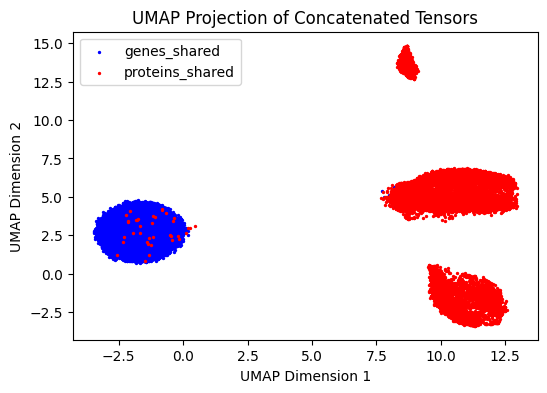

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


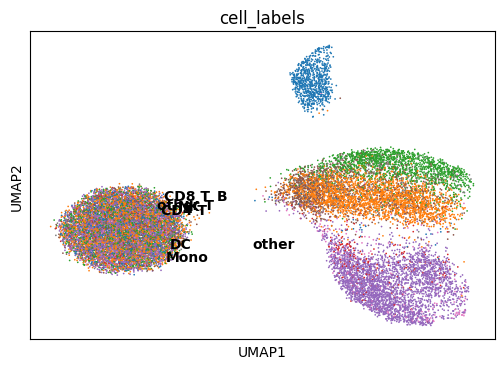

sharedloss: 15018.742956542968 || unsharedrloss: 55680.15124511719 || unsharedploss: 3683.97682800293 || embploss: 4.440464437007904 || embrloss: 2.9528809189796448


Epoch: 20: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  7.18it/s]


Adjusted Rand Index (ARI): 0.2638883149673092


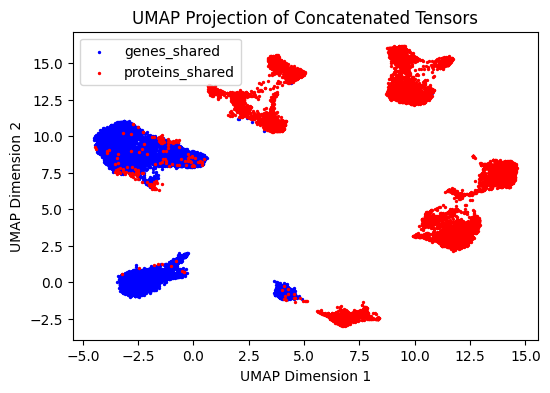

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


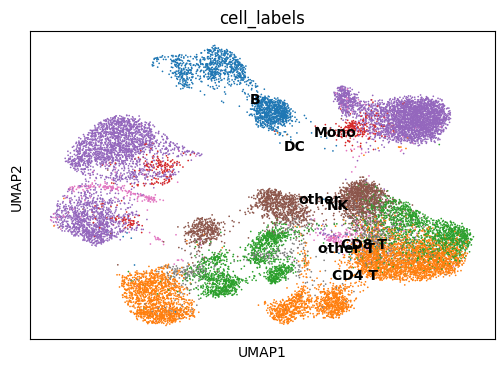

sharedloss: 7521.8518737792965 || unsharedrloss: 8195.222125244141 || unsharedploss: 1539.6932800292968 || embploss: 2.582230719923973 || embrloss: 2.2385354578495025


Epoch: 40: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.33it/s]


Adjusted Rand Index (ARI): 0.35675980546035924


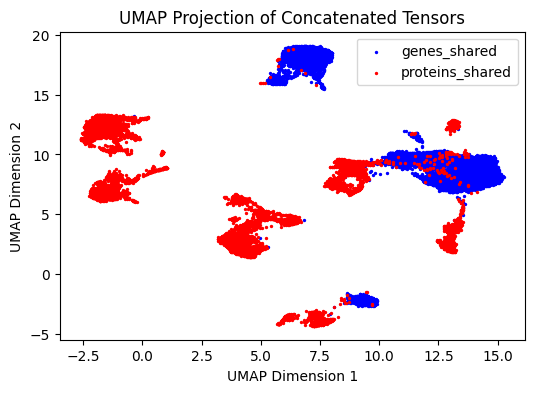

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


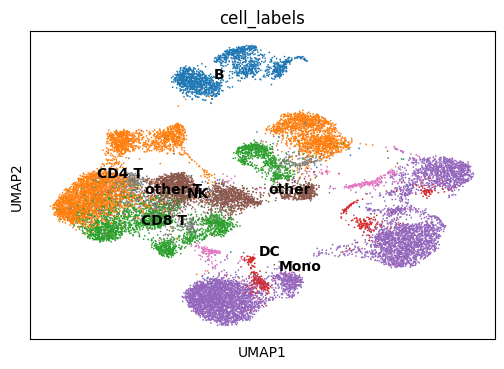

sharedloss: 7227.995739746094 || unsharedrloss: 7881.372039794922 || unsharedploss: 1444.5886215209962 || embploss: 2.432389643788338 || embrloss: 2.22401185631752


Epoch: 60: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.74it/s]


Adjusted Rand Index (ARI): 0.3049527972365775


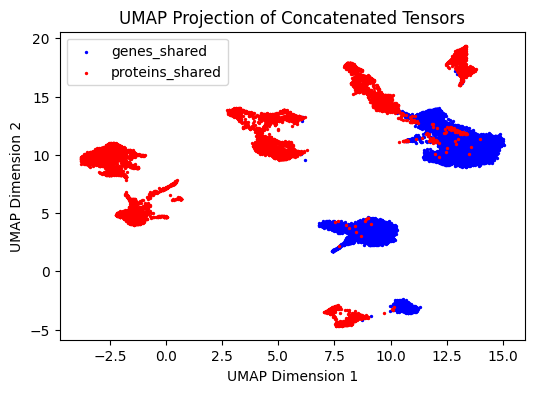

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


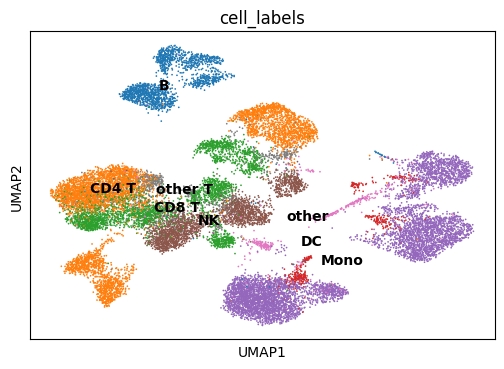

sharedloss: 7080.698583984375 || unsharedrloss: 7752.852624511719 || unsharedploss: 1406.1133911132813 || embploss: 2.49291869699955 || embrloss: 2.282528331875801


Epoch: 80: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.98it/s]


Adjusted Rand Index (ARI): 0.32278159181302785


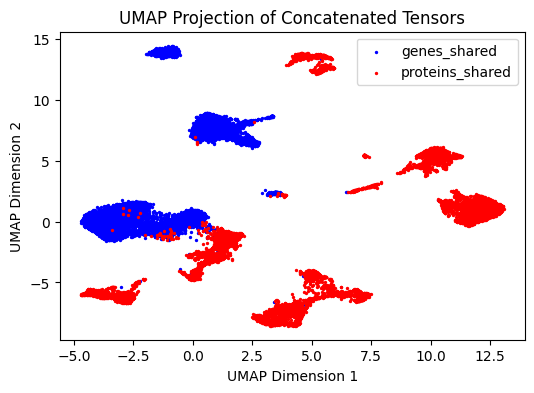

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


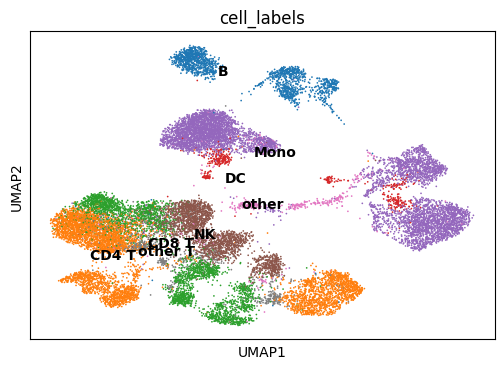

sharedloss: 6985.980126953125 || unsharedrloss: 7608.761798095703 || unsharedploss: 1383.709181213379 || embploss: 2.515516537427902 || embrloss: 2.2920619517564775


Epoch: 100: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.23it/s]


Adjusted Rand Index (ARI): 0.31693773390224256


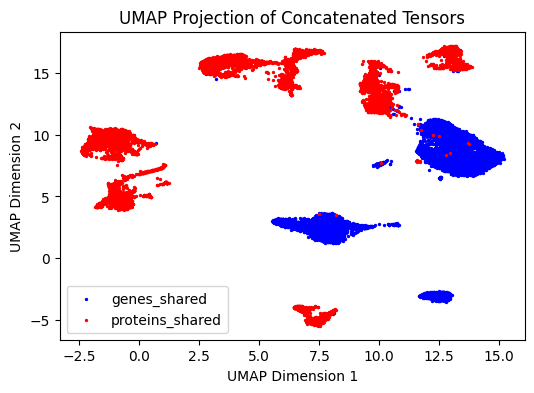

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


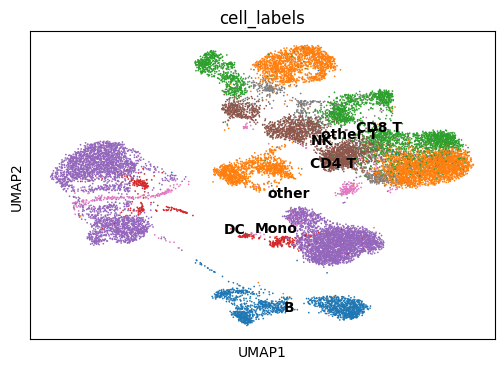

sharedloss: 6925.274053955078 || unsharedrloss: 7543.970404052734 || unsharedploss: 1369.2203338623046 || embploss: 2.5088333785533905 || embrloss: 2.28737930059433


Epoch: 120: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.60it/s]


Adjusted Rand Index (ARI): 0.3896414705650029


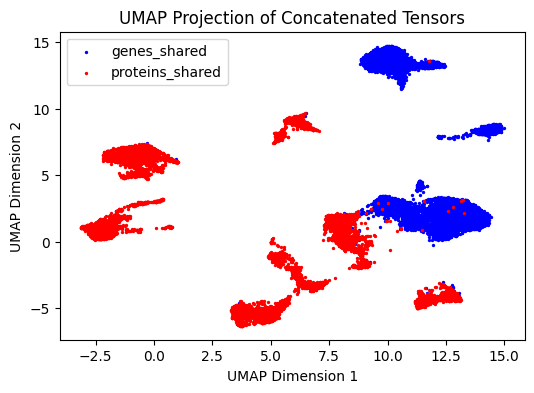

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


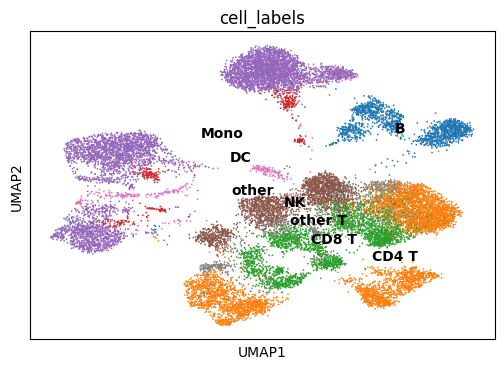

sharedloss: 6882.1695007324215 || unsharedrloss: 7452.124481201172 || unsharedploss: 1360.9950103759766 || embploss: 2.4681744068861007 || embrloss: 2.282556247711182


Epoch: 140: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.19it/s]


Adjusted Rand Index (ARI): 0.3386297141531551


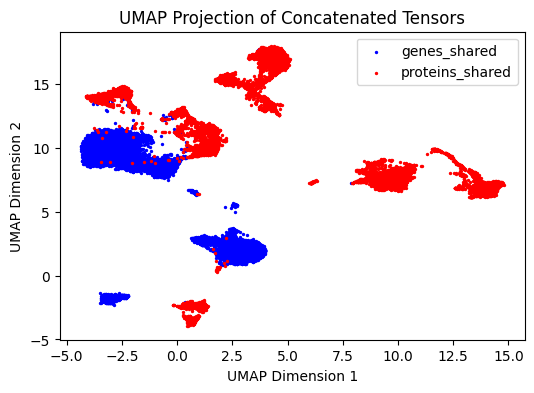

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


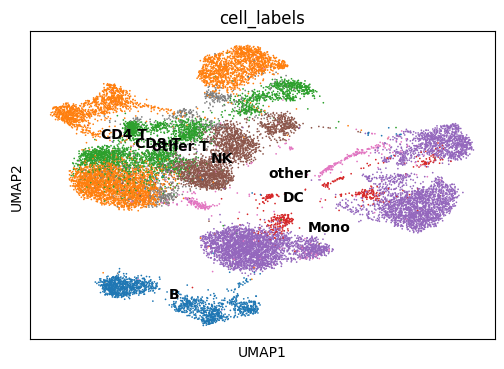

sharedloss: 6876.650988769531 || unsharedrloss: 7402.0421875 || unsharedploss: 1359.403579711914 || embploss: 2.439098170399666 || embrloss: 2.2877346754074095


Epoch: 160: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.47it/s]


Adjusted Rand Index (ARI): 0.4165230280802279


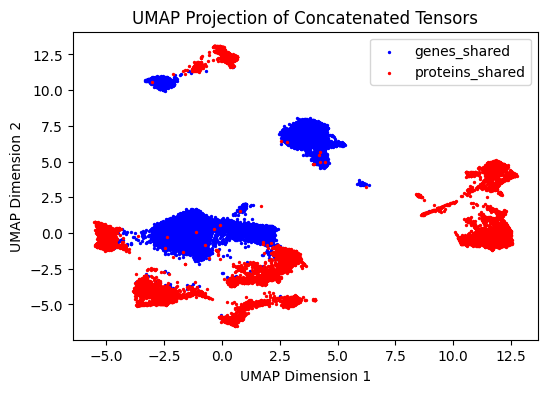

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


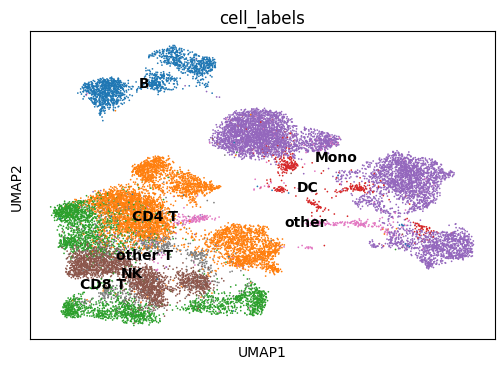

sharedloss: 6839.794738769531 || unsharedrloss: 7367.353570556641 || unsharedploss: 1352.0991744995117 || embploss: 2.4106400847434997 || embrloss: 2.25555177628994


Epoch: 180: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.30it/s]


Adjusted Rand Index (ARI): 0.37653736091535517


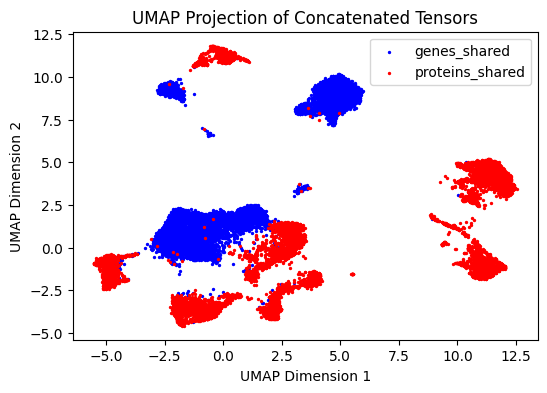

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


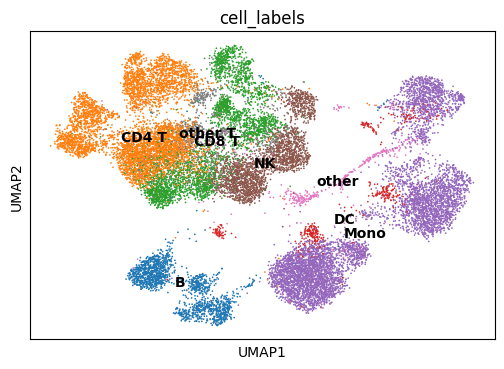

sharedloss: 6819.674188232422 || unsharedrloss: 7328.652893066406 || unsharedploss: 1347.1485733032227 || embploss: 2.3826040089130402 || embrloss: 2.2507016390562056


Epoch: 199: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.22it/s]


In [4]:
import torch.nn as nn
from scvi.models.vae import VAE_shared
from scvi.models.proteinvi import ProteinVI_shared
from scvi.models.totalvi import TOTALVI_shared
import torch.nn.functional as F

from sklearn.metrics import adjusted_rand_score,accuracy_score
import numpy as np
import umap
import anndata
import scanpy as sc
import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

nlayers = 2
#Unshared model protein
podel = ProteinVI_shared(54,54,latent_distribution="normal",log_variational=True,n_layers_encoder = nlayers,n_layers_decoder = nlayers)
#Unshared model RNA
rodel = VAE_shared(1915,1915,latent_distribution="normal",log_variational=True,n_layers = nlayers,reconstruction_loss = 'zinb')
#shared model protein-RNA
prodel = TOTALVI_shared(170,latent_distribution="normal",log_variational=True,n_layers_encoder = nlayers,n_layers_decoder = nlayers,reconstruction_loss_gene = "zinb")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
podel.to(device)
rodel.to(device)
prodel.to(device)


podel_params = filter(lambda p: p.requires_grad, podel.parameters())
rodel_params = filter(lambda p: p.requires_grad, rodel.parameters())
prodel_params = filter(lambda p: p.requires_grad, prodel.parameters())

optimizer_p = torch.optim.Adam(podel_params, lr=0.001, eps=0.01)
optimizer_r = torch.optim.Adam(rodel_params, lr=0.001, eps=0.01)
optimizer_pr = torch.optim.Adam(prodel_params, lr=0.001, eps=0.01)


Unshared_protein_loss = []
Unshared_rna_loss = []
Shared_loss = []
loss_emb_p = []
loss_emb_r = []

final_unshared_protein_loss = 0.0
final_unshared_rna_loss = 0.0
final_shared_loss = 0.0
final_loss_emb_p = 0.0
final_loss_emb_r = 0.0
kl_weight = 0.0

def distance_pred(latent1 , latent2):
    distances = torch.zeros(latent1.shape[0], latent2.shape[0])
    for i in range(latent1.shape[0]):
        distances[i,:] = torch.norm(latent2 - latent1[i], dim=1)  # Calculate Euclidean distance
    return distances
    
for epoch in range(400):
    final_unshared_protein_loss = 0.0
    final_unshared_rna_loss = 0.0
    final_shared_loss = 0.0
    final_loss_emb_p = 0.0
    final_loss_emb_r = 0.0    
    for y_shared,x_shared,y_unshared,x_unshared in tqdm(train_dataloader,desc="Epoch: {}".format(epoch)):
        optimizer_p.zero_grad()
        optimizer_r.zero_grad()
        optimizer_pr.zero_grad()
    
        y_shared = y_shared.to(device)
        x_shared = x_shared.to(device)
        y_unshared = y_unshared.to(device)
        x_unshared = x_unshared.to(device)
        drna_shared = dataset[0][1].view(1,-1).to(device)
        drna_unshared = dataset[0][0].view(1,-1).to(device)
        dprotein_shared = dataset[10000][1].view(1,-1).to(device)
        dprotein_unshared = dataset[10000][0].view(1,-1).to(device)
    
        y_shared = torch.cat([y_shared,dprotein_shared],dim=0)
        y_unshared = torch.cat([y_unshared,dprotein_unshared],dim=0)
        x_shared = torch.cat([x_shared,drna_shared],dim=0)
        x_unshared = torch.cat([x_unshared,drna_unshared],dim=0)
    
        local_mean = dataset.local_mean.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        local_var = dataset.local_var.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        
    
        ## forward pass of unshared network of proteins
        output_p = podel(y_unshared)
        unshared_protein_loss = torch.mean(5*output_p[0] + output_p[1] + output_p[2])
        with torch.no_grad():
            outputs = prodel(x_shared,y_shared,local_mean,local_var)
        loss_embedd_p = F.l1_loss(output_p[3],outputs[6])
        unshared_protein_loss += loss_embedd_p
        final_unshared_protein_loss += unshared_protein_loss.item()
        unshared_protein_loss.backward()
        optimizer_p.step()


        ## forward pass of unshared network of RNA
        loss_r,output_r = rodel(x_unshared,local_mean,local_var)
        unshared_rna_loss = torch.mean(7*loss_r[0]+loss_r[1])
        with torch.no_grad():
            outputs = prodel(x_shared,y_shared,local_mean,local_var)
        loss_embedd_r = F.l1_loss(outputs[5],output_r)
        unshared_rna_loss +=  loss_embedd_r
        final_unshared_rna_loss += unshared_rna_loss.item()
        unshared_rna_loss.backward()
        optimizer_r.step()

        
        ## forward pass of shared_network
        outputs = prodel(x_shared,y_shared,local_mean,local_var)
        size_output = outputs[2].shape[0]
        shared_loss = torch.mean(5*outputs[0] + outputs[3]) + torch.mean(outputs[2]) + torch.mean(7*outputs[1] + outputs[4])
        z_gene_shared = outputs[5]
        z_protein_shared = outputs[6]
        with torch.no_grad():
            output_p = podel(y_unshared)
            _,output_r = rodel(x_unshared,local_mean,local_var)

        loss_embedd_p = F.l1_loss(outputs[6],output_p[3])
        loss_embedd_r = F.l1_loss(outputs[5],output_r)
        shared_loss += loss_embedd_p + loss_embedd_r
        final_shared_loss += shared_loss.item()
        final_loss_emb_p += loss_embedd_p.item()
        final_loss_emb_r += loss_embedd_r.item()
        shared_loss.backward()
        optimizer_pr.step()
        
    
    Unshared_protein_loss.append(final_unshared_protein_loss)
    Unshared_rna_loss.append(final_unshared_rna_loss)
    Shared_loss.append(final_shared_loss)
    loss_emb_p.append(final_loss_emb_p)
    loss_emb_r.append(final_loss_emb_r)

    if epoch % 20 == 0:
        """Testing loop and visualisation saving"""
        with torch.no_grad():
            protein_data = torch.Tensor(dataset.protein_dataset)
            rna_data = torch.Tensor(dataset.data)
            # print(protein_data.shape, rna_data.shape)
            protein_shared = protein_data[:,dataset.shared_idx_protein].to(device)
            protein_unshared = protein_data[:,dataset.unshared_protein_idx].to(device)
            rna_shared = rna_data[:,dataset.shared_idx_rna].to(device)
            rna_unshared = rna_data[:,dataset.unshared_rna_idx].to(device)
            
            shared_tensor_mean = dataset.local_mean.reshape(-1,1).expand(10000, 1).to(device)
            shared_tensor_var = dataset.local_var.reshape(-1,1).expand(10000, 1).to(device)            
            outputs = prodel(rna_shared,protein_shared,shared_tensor_mean,shared_tensor_var)
            z_gene_shared = outputs[5]
            z_protein_shared = outputs[6]
            
            labels = []
            for row1 in z_gene_shared:
                distances = torch.norm(z_protein_shared - row1, dim=1)  # Calculate Euclidean distance
                closest_index = torch.argmin(distances) # Get the index of the minimum distance
                labels.append(closest_index.item())
                
            # Convert labels to tensor
            labels_tensor_rna = torch.tensor(labels)
            labels_protein_matrix = protein_adata.obs.copy()
            labels_rna_matrix = rna_adata.obs.copy()
            
            labels_rna = labels_rna_matrix.iloc[labels_tensor_rna.numpy()]
            labels_rna.reset_index(drop=True, inplace=True)
            
            ari = adjusted_rand_score(labels_rna_matrix['celltype.l1'],labels_rna['celltype.l1'])
            accuracy = accuracy_score(labels_rna_matrix['celltype.l1'],labels_rna['celltype.l1'])
            print(f"Adjusted Rand Index (ARI_without_thresholding): {ari}")
            print(f"Accuracy (Acc_without_thresholding): {accuracy}")
            
            tensor1 = z_gene_shared.cpu()
            tensor2 = z_protein_shared.cpu()
            concatenated_tensor = np.concatenate((tensor1, tensor2), axis=0)
            n_components = 2
            umap_reducer = umap.UMAP(n_components=n_components)
            umap_result = umap_reducer.fit_transform(concatenated_tensor)
            plt.scatter(umap_result[:10000, 0], umap_result[:10000, 1], c='blue', label='genes_shared',s=2)
            plt.scatter(umap_result[10000:, 0], umap_result[10000:, 1], c='red', label='proteins_shared',s=2)
            plt.title('UMAP Projection of Concatenated Tensors')
            plt.xlabel('UMAP Dimension 1')
            plt.ylabel('UMAP Dimension 2')
            plt.legend()
            plt.show()
            
            tensor1_labels = np.array(labels_rna_matrix['celltype.l1'])
            concatenated_labels = np.concatenate((tensor1_labels,tensor1_labels), axis=0)
            adata = anndata.AnnData(X=concatenated_tensor)
            adata.obs['cell_labels'] = concatenated_labels
            sc.pp.neighbors(adata)
            sc.tl.umap(adata)
            sc.pl.umap(adata, color='cell_labels', legend_loc='on data')
            plt.show()
            print("sharedloss: {} || unsharedrloss: {} || unsharedploss: {} || embploss: {} || embrloss: {}".format(final_shared_loss/80,final_unshared_rna_loss/80,final_unshared_protein_loss/80,final_loss_emb_p/80,final_loss_emb_r/80))

            output_latentp = z_protein_shared
            output_latentr = z_gene_shared
            distances_m = np.zeros((output_latentp.shape[0], output_latentr.shape[0]))
            distances_m = distance_pred(output_latentp,output_latentr)
            pro_2_rna_min_idx = np.argmin(distances_m, axis=0, keepdims=True)
            pro_2_rna_min_dist = np.min(np.array(distances_m), axis=0, keepdims=True)
            percentile_value = np.percentile(pro_2_rna_min_dist, 20)
            sure_cells_idx = np.nonzero(pro_2_rna_min_dist<percentile_value)
            unsure_cells_idx = np.nonzero(pro_2_rna_min_dist>=percentile_value)
            sure_cell_matrix = output_latentr[sure_cells_idx[1],:]
            unsure_cell_matrix = output_latentr[unsure_cells_idx[1],:]
            distance_new = distance_pred(sure_cell_matrix, unsure_cell_matrix)
            new_unsure_idx = np.argmin(distance_new, axis=0, keepdims=True)
            labels_protein_all = labels_l1[pro_2_rna_min_idx[0]]
            sure_cell_labels = labels_protein_all[sure_cells_idx[1]]
            unsure_cell_labels = sure_cell_labels[new_unsure_idx[0]]
            labels_protein_all[unsure_cells_idx[1]] = unsure_cell_labels
            
            accuracy = accuracy_score(labels_rna_matrix['celltype.l1'],labels_protein_all)
            ari = adjusted_rand_score(labels_rna_matrix['celltype.l1'],labels_protein_all)

            print(f"Adjusted Rand Index (ARI_with_thresholding): {ari}")
            print(f"Accuracy (Acc_with_thresholding): {accuracy}")
            

            